# Phenomenological hydrodynamic equations with constant coeffcients

The density fields $\rho$ and momentum fields $\mathbf{m}$ are evolved according to
$$
\begin{align*}
\partial_t \rho &= -v_0 \nabla \cdot \mathbf{m}, \\
\partial_t \mathbf{m} + \xi (\mathbf{m} \cdot \nabla) \mathbf{m} &= D\nabla^2 \mathbf{m} - \lambda \nabla \rho + a_2 \mathbf{m} - a_4 |\mathbf{m}|^2 \mathbf{m},
\end{align*}
$$
where the transport coeffcients $v_0$, $\xi$, $D$, $\lambda$ and $a_4$ are constant, while keepging an explicit density dependence in $a_2:\ a_2(\rho)=\rho-\phi_g$, where $\phi_g$ is the gas spinodal, smaller than the liquid spinodal $\phi_l=\phi_g+\frac{1}{4a_4 v_0 + 2\lambda}$. 
Introducing $\mathbf{m} = (m_x, m_y)$, the equations become
$$
\begin{align*}
\partial_t \rho &= -v_0 (\partial_x m_x + \partial_y m_y),\\
\partial_t m_x + \xi (m_x \partial_x + m_y \partial_y) m_x & = D(\partial_x^2+\partial_y^2) m_x - \lambda \partial_x \rho + a_2 m_x - a_4 m^2 m_x,\\
\partial_t m_y + \xi (m_x \partial_x + m_y \partial_y) m_y & = D(\partial_x^2+\partial_y^2) m_y - \lambda \partial_y \rho + a_2 m_y - a_4 m^2 m_y,
\end{align*}
$$
where $m^2=|\mathbf{m}|^2=m_x^2+m_y^2$.

In Fourier space, we have 
$$
\begin{align*}
\partial_t \tilde{\rho} &= -iv_0(k_x \tilde{m}_x + k_y \tilde{m}_y), \\
\partial_t \tilde{m}_x &= -\xi \left(
    \frac{i k_x}{2} \widetilde{m_x^2} + \widetilde{m_y\partial_y m_x}
    \right) - k^2 D \tilde{m}_x - ik_x\lambda \tilde{\rho} + \widetilde{\rho m_x} - \phi_g\tilde{m}_x - a_4 \widetilde{m^2m_x},\\
\partial_t \tilde{m}_y &= -\xi \left(
    \frac{i k_y}{2} \widetilde{m_y^2} + \widetilde{m_x\partial_x m_y}
    \right) - k^2 D \tilde{m}_y - ik_y\lambda \tilde{\rho} + \widetilde{\rho m_y} - \phi_g\tilde{m}_y - a_4 \widetilde{m^2m_y},
\end{align*}
$$
where $k^2=k_x^2+k_y^2$.

In [7]:
import numpy as np
from coord import get_freq
from fields import show_fields, ini_fields, dump_fields

def eval_time_derivative(rho, rho_hat, mx, mx_hat, my, my_hat, kx, ky, k2, v0, xi, D, lambdaa, phi_g, a4):
    mx2 = mx ** 2
    my2 = my ** 2
    mx2_hat = np.fft.rfft2(mx2)
    my2_hat = np.fft.rfft2(my2)
    
    my_dy_mx_hat = np.fft.rfft2(my * np.fft.irfft2(1j * ky * mx_hat))
    mx_dx_my_hat = np.fft.rfft2(mx * np.fft.irfft2(1j * kx * my_hat))

    rho_mx_hat = np.fft.rfft2(rho * mx)
    rho_my_hat = np.fft.rfft2(rho * my)

    m2 = mx2 + my2
    m2_mx_hat = np.fft.rfft2(m2 * mx)
    m2_my_hat = np.fft.rfft2(m2 * my)

    f_rho = -1j * v0 * (kx * mx_hat + ky * my_hat)

    k2_D_plus_phi_g = k2 * D + phi_g
    i_lambda_rho_hat = 1j * lambdaa * rho_hat
    f_mx = -xi * (0.5j * kx * mx2_hat + my_dy_mx_hat) - k2_D_plus_phi_g * mx_hat - kx * i_lambda_rho_hat + rho_mx_hat - a4 * m2_mx_hat
    f_my = -xi * (0.5j * ky * my2_hat + mx_dx_my_hat) - k2_D_plus_phi_g * my_hat - ky * i_lambda_rho_hat + rho_my_hat - a4 * m2_my_hat
    return f_rho, f_mx, f_my


def exEulerFS(rho_hat, mx_hat, my_hat, kx, ky, k2, v0, xi, D, lambdaa, phi_g, a4, dt):
    rho = np.fft.irfft2(rho_hat)
    mx = np.fft.irfft2(mx_hat)
    my = np.fft.irfft2(my_hat)

    f_rho, f_mx, f_my = eval_time_derivative(rho, rho_hat, mx, mx_hat, my, my_hat, kx, ky, k2, v0, xi, D, lambdaa, phi_g, a4)
    
    rho_hat_next = rho_hat + dt * f_rho
    mx_hat_next = mx_hat + dt * f_mx
    my_hat_next = my_hat + dt * f_my

    return rho_hat_next, mx_hat_next, my_hat_next




In [8]:
def run_exEulerFS(n_step, dn_out, dt, dx, fout, v0, xi, D, lambdaa, phi_g, a4, kx, ky, k2, rho, mx, my, t0):
    n_frame = n_step // dn_out
    rho_hat =  np.fft.rfft2(rho)
    mx_hat = np.fft.rfft2(mx)
    my_hat = np.fft.rfft2(my)

    Ny, Nx = rho.shape
    rho_arr, mx_arr, my_arr = np.zeros((3, n_frame, Ny, Nx))
    t_arr = np.zeros(n_frame)
    i_frame = 0
    for j in range(1, n_step+1):
        if j % dn_out == 0:
            t = t0 + dt * j
            rho = np.fft.irfft2(rho_hat)
            mx = np.fft.irfft2(mx_hat)
            my = np.fft.irfft2(my_hat)
            dump_fields(rho_arr, mx_arr, my_arr, t_arr, rho, mx, my, t, i_frame)
            show_fields(rho, mx, my, t, dx)
            i_frame += 1
        rho_hat, mx_hat, my_hat = exEulerFS(rho_hat, mx_hat, my_hat, kx, ky, k2, v0, xi, D, lambdaa, phi_g, a4, dt)
    
    # np.savez_compressed(fout, rho_arr=rho_arr, px_arr=px_arr, py_arr=py_arr, t_arr=t_arr)


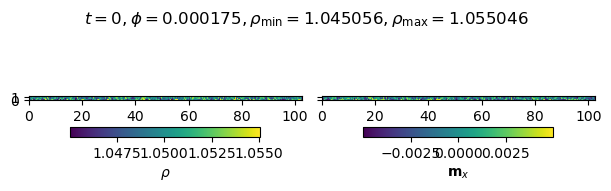

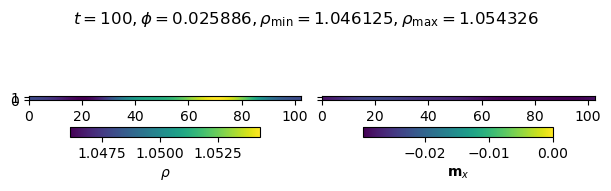

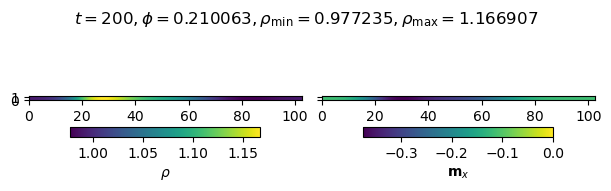

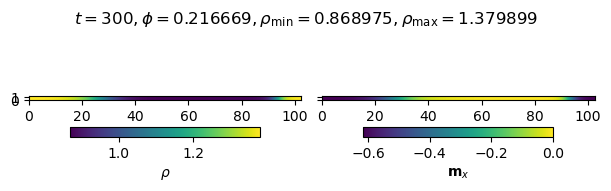

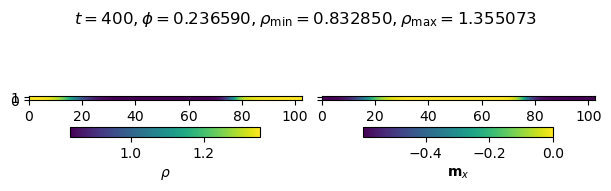

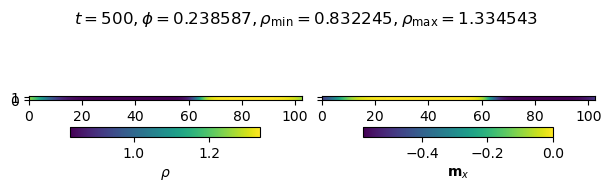

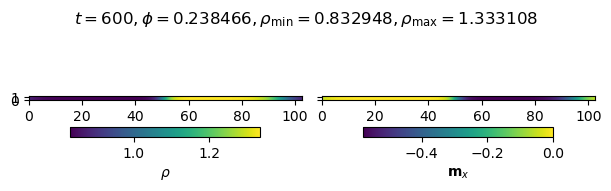

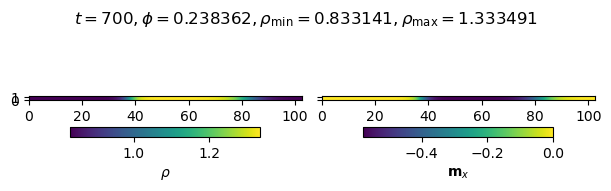

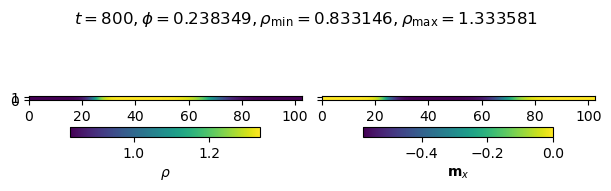

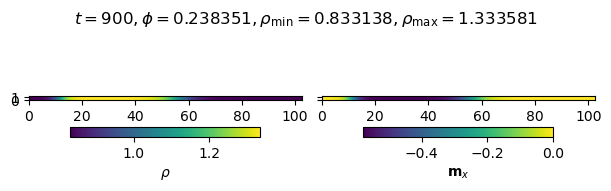

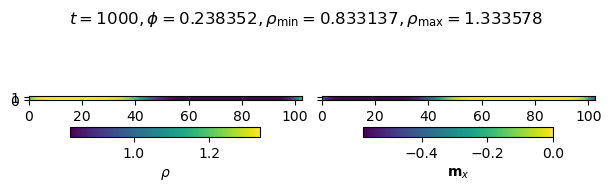

In [12]:
dt = 1e-2
spacing = 0.4
Nx = 256 # Nx and Ny should be even
Ny = 4
Lx = Nx * spacing
Ly = Ny * spacing


kx, ky, k2 = get_freq(Nx, Ny, spacing)

rho0 = 1.05
seed = 100
ini_mode = "rand"

v0 = 1.
lambdaa =1.
xi = 1.
D = 1.
a4 = 1.
phi_g = 1.
np.random.seed(seed)

folder = "data"
fout = f"{folder}/L{Lx:g}_{Ly:g}_r{rho0:g}_v{v0:g}_l{lambdaa:g}_a{a4:g}_g{phi_g}_dx{spacing:g}_dt{dt:g}_s{seed}.npz"

rho, mx, my, t0 = ini_fields(fout, ini_mode, spacing, Nx, Ny, rho0)

n_step = 100000
dn_out = 10000

# run_exEulerFS(n_step, dn_out, dt, spacing, fout, v0, xi, D, lambdaa, phi_g, a4, kx, ky, k2, rho, mx, my, t0)
